# Derby 2022 Analysis - A Refined Framework

### Claimer:
This notes book was developed based on the notebook by Matt OP: https://www.kaggle.com/code/mattop/big-data-derby-2022-eda. Hoever, I believe my efforts have made my version different enough as a separate study.

In [ ]:
# load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px #graphing
import plotly.graph_objects as go #graphing
from plotly.subplots import make_subplots #graphing
import plotly.figure_factory as ff #graphing
import matplotlib.pyplot as plt #graphing
import seaborn as sns #graphing
import missingno as msno #describe data
import os
import math
from sklearn.manifold import TSNE

colors = ["#FFFFFF", "#6CD4FF", "#F7DF00", "#E60000"]

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
pd.set_option('display.max_rows', 2000)

plt.rcParams["figure.figsize"] = (12, 8)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# define helper functions
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
def cal_dist(x_1,y_1,x_2,y_2):

    R = 6373.0

    lat1 = radians(x_1)
    lon1 = radians(y_1)
    lat2 = radians(x_2)
    lon2 = radians(y_2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

#print("Result:", distance*1000)
#print("Should be:", 278.546, "km")

def getEndpoint(bearing,d,lat1,lon1):
    R = 6371                     #Radius of the Earth
    brng = math.radians(bearing) #convert degrees to radians
    #d = d*1.852                  #convert nautical miles to km
    lat1 = math.radians(lat1)    #Current lat point converted to radians
    lon1 = math.radians(lon1)    #Current long point converted to radians
    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) + math.cos(lat1)*math.sin(d/R)*math.cos(brng))
    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),math.cos(d/R)-math.sin(lat1)*math.sin(lat2))
    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)
    return lat2,lon2

def get_bearing(lat1, long1, lat2, long2):
    startLat = math.radians(lat1)
    startLong = math.radians(long1)
    endLat = math.radians(lat2)
    endLong = math.radians(long2)

    dLong = endLong - startLong

    dPhi = math.log(math.tan(endLat/2.0+math.pi/4.0)/math.tan(startLat/2.0+math.pi/4.0))
    if abs(dLong) > math.pi:
         if dLong > 0.0:
             dLong = -(2.0 * math.pi - dLong)
         else:
             dLong = (2.0 * math.pi + dLong)

    bearing = (math.degrees(math.atan2(dLong, dPhi)) + 360.0) % 360.0
    
    return bearing

# 0. Introduction

This notebook is developed to study various factors that might be relevant to horse race. The notebook organized as follows. Section I mainly focused on basic cleaning and merge operations. Section II tried to contruct features that might be useful for further analysis. Section III deals with explorative analysis while Section IV is left for statistical analysis.

In [ ]:
# load dataset
nyra_2019 = pd.read_csv("/kaggle/input/big-data-derby-2022/nyra_2019_complete.csv")
nyra_finishing = pd.read_csv("../input/big-data-derby-2022-global-horse-ids-and-places/horse_ids.csv")
nyra_corner = pd.read_csv("../input/derby/Track_Corner.csv")

# 1. Merge and Clean

1. For NYRA data, distance_id is reported in fulrong and needs to be transformed to kms
2. Nyra_corner is a dataset collected by myself based on google map. In the dataset, the cordinates of corners of each track were recorded. Therefore, this dataset can be used to calculate the length of the straight part and the corner part of the track.
3. Nyra_finishing is public dataset avaiable on Kaggel that reports the finishing position of each race. However, it has a lot of missing values, which I will try to correct in the later part of the notebook.

In [ ]:
nyra_2019['dis_race']=nyra_2019['distance_id']*0.201168/100

# calculate length of the straight tracks
dis_KM=[]

for i in range(len(nyra_corner)):
    x_1 =nyra_corner['CP1_lat'][i]
    y_1 =nyra_corner['CP1_lon'][i]
    x_2 =nyra_corner['CP2_lat'][i]
    y_2 =nyra_corner['CP2_lon'][i]

    A=cal_dist(x_1,y_1,x_2,y_2)
    dis_KM.append(A)

nyra_corner['straight']=dis_KM  
nyra_corner['length_lap']=  2*(nyra_corner['straight']+nyra_corner['corner'])

In [ ]:
# create merge key
key_columns = ["track_id", "race_date", "race_number"]
nyra_2019["race_id"] = nyra_2019[key_columns].astype(str).agg('_'.join, axis=1)
key_columns = ["track_id", "race_date", "race_number",'program_number']
nyra_2019["pro_id"] = nyra_2019[key_columns].astype(str).agg('_'.join, axis=1)
key_columns = ["track_id", "race_date", "race",'program_number']
nyra_finishing["pro_id"] = nyra_finishing[key_columns].astype(str).agg('_'.join, axis=1)
key_columns = ["track_id", "course_type"]
nyra_2019["track_course"] = nyra_2019[key_columns].astype(str).agg('_'.join, axis=1)
nyra_corner["track_course"] = nyra_corner[key_columns].astype(str).agg('_'.join, axis=1)

In [ ]:
# merge with finishing data (need to revise later)
nyra_finishing=nyra_finishing.iloc[: , 1:]
nyra_finishing =nyra_finishing.drop(["track_id", "race_date", "race",'program_number'], axis = 1) 
nyra_corner=nyra_corner.drop(['course_type'], axis = 1) 
primary=nyra_2019.merge(nyra_finishing,how = 'left', on = 'pro_id').merge(nyra_corner,how = 'left', on = 'track_course')
primary.head(5)

In [ ]:
# Initialize dataframe for statistical analysis
temp_2=primary[['race_id','jockey','track_id_x', 'race_date', 'race_number', 'program_number', 'distance_id', 'course_type',
       'track_condition', 'run_up_distance', 'race_type', 'purse', 'weight_carried',  'odds',  'track_course', ]]

temp_2 = temp_2.drop_duplicates()
temp_2 = temp_2.sort_values(by = ['race_id','jockey'], ascending = True)
temp_2=temp_2.reset_index(drop=True)

Stat_main=temp_2 

In [ ]:
# calculate distance to check point for each trakus index
primary['D_1']=np.sqrt((primary['latitude']-primary['CP1_lat'])**2+(primary['longitude']-primary['CP1_lon'])**2)*1000
primary['D_2']=np.sqrt((primary['latitude']-primary['CP2_lat'])**2+(primary['longitude']-primary['CP2_lon'])**2)*1000
primary['D_3']=np.sqrt((primary['latitude']-primary['CP3_lat'])**2+(primary['longitude']-primary['CP3_lon'])**2)*1000
primary['D_4']=np.sqrt((primary['latitude']-primary['CP4_lat'])**2+(primary['longitude']-primary['CP4_lon'])**2)*1000
primary['D_5']=np.sqrt((primary['latitude']-primary['CP5_lat'])**2+(primary['longitude']-primary['CP5_lon'])**2)*1000
primary['D_6']=np.sqrt((primary['latitude']-primary['CP6_lat'])**2+(primary['longitude']-primary['CP6_lon'])**2)*1000

As I mentioned above, the nyra_finishing data has a lot of missing values. To find/estimate the finishing position of each race, I used the below strategy, which shares the same spirit as [xxxx], but is probably a more systemical method.

Basic logic:
1. I use the average of the cordinates reported where trakus_index = 1 as the starting line of each race. This is reasonable because at the very beginning, there shouldn't be a huge different between different horse.
2. For each race, the total length of the race is reported through the variable "distance_id", which I later transformed to kilometers.
3. Based on the dataset on corners and straights, I approximate the location of the finishing line with a simple math: start + race length = finishing. It is known that all races are counter-clockwise and I assume races only starts/finishes on the straight part of the track.
4. For example, I can calculate the distance based on cordinates. The length of curve is mannually measured through Google Map. Then, I know how much distance is left. Now, based on the cordiantes of the two corners, I can calcualted the bearing and accompanied with the distance left, I can back out the location of the finishing position.
5. After obtaining the location of the finishing position, I calculate the distance between each cordinates reported for each trakus_index to the finishing location for each jockey and find the trakus_index whose distance is minimum for each jockey. The underlying logic is the faster the jockey, the sooner it will pass the finishing line, the smaller the trakus_index.
6. Finally, for each race, I sort jockeys by trakus_index in ascending order to determine the final position
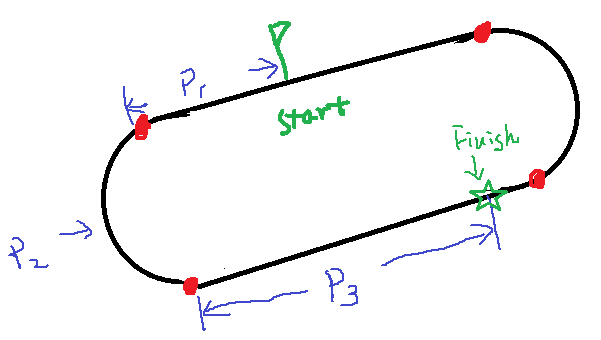

In [ ]:
'''
# calculate finishing cordinates
temp=primary[['race_id','jockey','latitude','longitude','trakus_index','finishing_place','dis_race','length_lap','corner','straight','course_type','CP1_lat','CP2_lat','CP3_lat','CP4_lat','CP1_lon','CP2_lon','CP3_lon','CP4_lon']]
temp_2=temp[(temp["trakus_index"] == 1)]
temp_2['lat_start'] = temp_2['latitude'].groupby(temp_2['race_id']).transform('mean')
temp_2['lon_start'] = temp_2['longitude'].groupby(temp_2['race_id']).transform('mean')
temp_2=temp_2.drop(['jockey'], axis = 1)
temp_2=temp_2.drop(['latitude','longitude'], axis = 1)
temp_2=temp_2.drop(['finishing_place'], axis = 1)
temp_2 = temp_2.drop_duplicates()
temp_2=temp_2.reset_index(drop=True)
temp_2['n_lap']=temp_2['dis_race']/temp_2['length_lap']

lat_f_list=[]
lon_f_list=[]

for i in range(len(temp_2)):
    lat_s = temp_2['lat_start'][i]
    lon_s = temp_2['lon_start'][i]

    lat_u =temp_2['CP1_lat'][i]
    lon_u =temp_2['CP1_lon'][i]

    lat_b =temp_2['CP3_lat'][i]
    lon_b =temp_2['CP3_lon'][i]

    curve = temp_2['corner'][i]
    total_dis =temp_2['dis_race'][i]
    track_len =temp_2['length_lap'][i]
    stra_len=temp_2['straight'][i]

    lat_ur =temp_2['CP2_lat'][i]
    lon_ur =temp_2['CP2_lon'][i]

    lat_br =temp_2['CP4_lat'][i]
    lon_br =temp_2['CP4_lon'][i]

    dis_u=cal_dist(lat_s,lon_s,lat_u,lon_u)
    dis_b=cal_dist(lat_s,lon_s,lat_b,lon_b)

    # if shorter than 1 lap
    if total_dis<track_len:

        # default to start from the upper part, use dis_u (distance to check point1) and dis_b (dis to cp3)
        # to determine where the race started
        dis_p1 = dis_u+curve
        brng=get_bearing(lat_b,lon_b,lat_br,lon_br)

        # if started in the lower part of the track
        if dis_u > dis_b:
            dis_p1 = (stra_len-dis_b)+curve

        # remaining distance  = total - start-cp1 - corner*1
        #dis_p1=dis_u+curve
        dis_left = total_dis - dis_p1

        # if remaining distance is less than 1 * straight line, which means the finishing point will be on this line
        if dis_left<=stra_len:
            lat_o,lon_o = lat_b, lon_b

            if dis_u > dis_b:
                lat_o,lon_o = lat_ur, lon_ur
                brng=get_bearing(lat_ur,lon_ur,lat_u,lon_u)

            lat_f,lon_f = getEndpoint(brng,dis_left,lat_o,lon_o)

        if dis_left>stra_len:
            dis_left = dis_left -0.5*track_len
            lat_o,lon_o = lat_ur, lon_ur
            brng=get_bearing(lat_ur,lon_ur,lat_u,lon_u)

            if dis_u > dis_b:
                lat_o,lon_o = lat_b, lon_b
                brng=get_bearing(lat_o,lon_o,lat_br,lon_br)

            lat_f,lon_f = getEndpoint(brng,dis_left,lat_o,lon_o)

    if total_dis>=track_len:
        total_dis = total_dis - track_len

        if dis_u <= dis_b:

            if total_dis<=dis_u:
                dis_left=total_dis
                lat_o,lon_o = lat_s, lon_s
                brng=get_bearing(lat_o,lon_o,lat_u,lon_u)
                lat_f,lon_f = getEndpoint(brng,dis_left,lat_o,lon_o)

            if total_dis>dis_u:
                dis_left=total_dis-dis_u-curve
                lat_o,lon_o = lat_b, lon_b
                brng=get_bearing(lat_o,lon_o,lat_br,lon_br)
                lat_f,lon_f = getEndpoint(brng,dis_left,lat_o,lon_o)

        if dis_u > dis_b:

            if total_dis<=(stra_len-dis_b):
                dis_left=total_dis
                lat_o,lon_o = lat_s, lon_s
                brng=get_bearing(lat_o,lon_o,lat_br,lon_br)
                lat_f,lon_f = getEndpoint(brng,dis_left,lat_o,lon_o)

            if total_dis>(stra_len-dis_b):
                dis_left=total_dis-(stra_len-dis_b)-curve
                lat_o,lon_o = lat_ur, lon_ur
                brng=get_bearing(lat_o,lon_o,lat_u,lon_u)
                lat_f,lon_f = getEndpoint(brng,dis_left,lat_o,lon_o)

    lat_f_list.append(lat_f)
    lon_f_list.append(lon_f)

temp_2['lat_finish']=lat_f_list
temp_2['lon_finish']=lon_f_list
finish_main=temp_2

# incorporate finishing cordinates
finish_main_s=finish_main[['race_id','lat_finish','lon_finish']]
primary=primary.merge(finish_main_s,how = 'left', on = 'race_id')

# prepare finish_main
temp_0=primary[['race_id','jockey','trakus_index','finishing_place','distance_id','latitude','longitude','course_type','lat_finish','lon_finish']]
finish_main=pd.DataFrame()
rid_list=list(temp_0['race_id'].unique())

for rid in rid_list:

    temp=temp_0[temp_0["race_id"] == rid]

    N=math.floor(0.7*temp[['trakus_index']].max())

    temp=temp.reset_index(drop=True)
    dis_KM=[]

    for i in range(len(temp)):
        x_1 =temp['latitude'][i]
        y_1 =temp['longitude'][i]
        x_2 =temp['lat_finish'][i]
        y_2 =temp['lon_finish'][i]

        A=cal_dist(x_1,y_1,x_2,y_2)
        dis_KM.append(A)

    temp['test_finish']=dis_KM

    # calculate finishing position

    #temp_2=temp[(temp["race_id"] == "SAR_2019-09-01_12") & (temp["trakus_index"] == 387)]
    #temp['test_finish']=np.sqrt((temp['latitude']-temp['lat_finish'])**2+(temp['longitude']-temp['lon_finish'])**2)
    temp = temp.drop(temp[temp.trakus_index < N].index)
    temp_3=pd.DataFrame(temp.groupby(['jockey'])['test_finish'].agg(min))
    temp_3=temp_3.merge(temp,how = 'left', on = ['jockey','test_finish'])

    temp_3["rank"] = temp_3.groupby("race_id")["trakus_index"].rank("min", ascending=True)
    temp_3['finishing_place'] = temp_3['finishing_place'].fillna(0)
    temp_3['fin_pos']=temp_3["rank"]
    temp_3.loc[temp_3['finishing_place'] !=0, 'fin_pos'] = temp_3['finishing_place']
    fin_pos_main=temp_3[['race_id','jockey','fin_pos']]
    del temp_3, temp
    
    finish_main=finish_main.append(fin_pos_main, ignore_index=True)

#finish_main.to_csv('finish_main.csv',index = False)
'''

As inspired by analysis from car racing, winning a race might not simply be a story of average speed over the entire race. It might be interesting to see the pace at different segment/stage of the race. I split each race by the four corners and try to explore the speed and acceleration of each segment (see details in feature engineering part)

In [ ]:
# prepare cp_main
rid_list=list(primary["race_id"].unique())
cp_list=['D_1','D_2','D_3','D_4','D_5','D_6']
cp_main=pd.DataFrame()

for rid in rid_list:

    test= primary[primary["race_id"] == rid]
    J_list=list(test['jockey'].unique())


    df_2 =pd.DataFrame(J_list)
    df_2.rename(columns={0: "jockey"},inplace=True)
    df_2['race_id']=rid
    
    i=1
    for each in cp_list:
        #new_name = "cp"+str(i)
        test_2=pd.DataFrame(test.groupby(['jockey'])[each].agg(min))
        #test_2.rename(columns={each: new_name},inplace=True)
        df_2=df_2.merge(test_2,how = 'left', on = 'jockey')
        i = i+1
        
    cp_main=cp_main.append(df_2, ignore_index=True)

In [ ]:
# dealing with time variables
primary['race_date'] = pd.to_datetime(primary['race_date'])
primary['day'], primary['month'] = primary['race_date'].dt.day, primary['race_date'].dt.month

# 2. Feature Engineering

In [ ]:
pri_lag=primary[['race_id','jockey','latitude','longitude','trakus_index','finishing_place','dis_race','length_lap','corner','straight','course_type','D_1','D_2','D_3','D_4','D_5','D_6']]
pri_lag = pri_lag.sort_values(by = ['race_id','jockey','trakus_index'], ascending = True)
shifted = pri_lag.groupby(['race_id','jockey']).shift(-1)
pri_lag=pri_lag.join(shifted.rename(columns=lambda x: x+"_lag"))

To construct the measure of spot speed and acceleration, I used two approach here. Approach 1 is to use cordinates of each trakus_index to calculate the distance travelled in each interval, which is a standard one. Approach 2 is a sloppy one because I treat the cordinates of lat and lon as if they are on a x-y system and calcualte the distance directly. However, in Section III you can see that Approach 2 gives a better visualization. Also, both approaches didn't translate into km/h measure for simplicity.

In [ ]:
# Calculate distance and accumulated distance
dis_KM=[]

for i in range(len(pri_lag)):
    x_1 =pri_lag['latitude'][i]
    y_1 =pri_lag['longitude'][i]
    x_2 =pri_lag['latitude_lag'][i]
    y_2 =pri_lag['longitude_lag'][i]

    A=cal_dist(x_1,y_1,x_2,y_2)
    dis_KM.append(A)

pri_lag['dist_km']=dis_KM
pri_lag['cum_dis'] = pri_lag.groupby(['race_id','jockey'])['dist_km'].cumsum()

In [ ]:
# Calculate Speed and Acceleration

pri_lag['v_t']=np.sqrt((pri_lag['latitude']-pri_lag['latitude_lag'])**2+(pri_lag['longitude']-pri_lag['longitude_lag'])**2)*10000
pri_lag['v_t_p']=pri_lag['dist_km']*1000
pri_lag['v_shifted'] = pri_lag.groupby(['race_id','jockey'])['v_t'].shift(-1)
pri_lag['v_shifted_p'] = pri_lag.groupby(['race_id','jockey'])['v_t_p'].shift(-1)

pri_lag['a_t']=(pri_lag['v_shifted']-pri_lag['v_t']) #/pri_lag['v_t']
pri_lag['a_t_p']=(pri_lag['v_shifted_p']-pri_lag['v_t_p']) #/pri_lag['v_t_p']
pri_lag=pri_lag.drop(['trakus_index_lag','finishing_place_lag', 'course_type_lag', 'D_1_lag', 'D_2_lag',
       'D_3_lag', 'D_4_lag', 'D_5_lag', 'D_6_lag'], axis = 1) 
pri_lag.head(5)

# highest speed for straight and corner
# avg spped for straight and corner
# highest acc, average acc,accumualted positive acc and negative acc
# spot speed/acc for corner points
# std speed/acc

In [ ]:
# prepare seg_main
rid_list=list(primary["race_id"].unique())
seg_main=pd.DataFrame()
seg_list=['D_1','D_2','D_3','D_4']

for rid in rid_list:
    seg_f1=pri_lag[pri_lag["race_id"] == rid]
    df_3 = cp_main[cp_main["race_id"] == rid]
    df_3=df_3.drop(['race_id'], axis = 1)

    i = 1

    for each in seg_list:
        seg_f2=seg_f1[['race_id','jockey',each,'trakus_index']]
        df_3=df_3.merge(seg_f2,how = 'left', on = ['jockey',each])
        df_3=df_3.drop(['race_id'], axis = 1) 

        new_1= 'trak_ind_cp'+str(i)

        df_3.rename(columns={'trakus_index': new_1},inplace=True)


        i = i+1

    df_3=df_3.drop(seg_list, axis = 1) 
    df_3=df_3.drop(['D_5','D_6'], axis = 1) 
    df_3['race_id']=rid
    
    seg_main=seg_main.append(df_3, ignore_index=True)
    
a=seg_main[['trak_ind_cp1','trak_ind_cp2','trak_ind_cp3','trak_ind_cp4']].values
a.sort(axis=1)
seg_main_s=pd.DataFrame(a, seg_main.index)
seg_main_s.rename(columns={0: "cp1", 1: "cp2", 2: "cp3", 3: "cp4"},inplace=True)
temp=seg_main[['race_id','jockey']]
seg_main_s = pd.concat([seg_main_s, temp], axis=1)

In [ ]:
# aggregate by segment
# prepare
pri_lag=pri_lag.merge(seg_main_s,how = 'left', on = ['race_id','jockey'])
pri_lag['segment']=0
pri_lag.loc[(pri_lag["trakus_index"] <= pri_lag["cp1"]), "segment"] = 1
pri_lag.loc[(pri_lag["trakus_index"] > pri_lag["cp1"]) & (pri_lag["trakus_index"] <= pri_lag["cp2"]), "segment"] = 2
pri_lag.loc[(pri_lag["trakus_index"] > pri_lag["cp2"]) & (pri_lag["trakus_index"] <= pri_lag["cp3"]), "segment"] = 3
pri_lag.loc[(pri_lag["trakus_index"] > pri_lag["cp3"]) & (pri_lag["trakus_index"] <= pri_lag["cp4"]), "segment"] = 4
pri_lag.loc[(pri_lag["trakus_index"] > pri_lag["cp4"]), "segment"] = 5

# aggregate
seg_agg_mean=pri_lag.groupby(['race_id','jockey','segment'],as_index=False)['v_t','a_t'].mean()
seg_agg_min=pri_lag.groupby(['race_id','jockey','segment'],as_index=False)['v_t','a_t'].min()
seg_agg_max=pri_lag.groupby(['race_id','jockey','segment'],as_index=False)['v_t','a_t'].max()
seg_agg_std=pri_lag.groupby(['race_id','jockey','segment'],as_index=False)['v_t','a_t'].std()

As inspired by analysis from car racing, jockeys' status and past performance might also be relevant factors to the final results.

In [ ]:
'''
# jockey features
# gap between matches - lead
jky_lag=primary[['race_id','jockey','race_date']]
jky_lag = jky_lag.sort_values(by = ['jockey','race_date'], ascending = True)
jky_lag = jky_lag.drop_duplicates()
jky_lag=jky_lag.reset_index(drop=True)
shifted = jky_lag.groupby(['jockey']).shift(1)
jky_lag=jky_lag.join(shifted.rename(columns=lambda x: x+"_lag"))
jky_lag=jky_lag.drop(['race_id_lag'], axis = 1) 
jky_lag['gap_days']=jky_lag['race_date']-jky_lag['race_date_lag']

jky_temp=jky_lag[['race_id','jockey', 'gap_days']]
del jky_lag
'''

In [ ]:
'''
# gap between matches - lag
jky_lag=primary[['race_id','jockey','race_date']]
jky_lag = jky_lag.sort_values(by = ['jockey','race_date'], ascending = True)
jky_lag = jky_lag.drop_duplicates()
jky_lag=jky_lag.reset_index(drop=True)
shifted = jky_lag.groupby(['jockey']).shift(-1)
jky_lag=jky_lag.join(shifted.rename(columns=lambda x: x+"_lead"))
jky_lag=jky_lag.drop(['race_id_lead'], axis = 1) 
jky_lag['lead_days']=jky_lag['race_date']-jky_lag['race_date_lead']

jky_temp_2=jky_lag[['race_id','jockey', 'lead_days']]
del jky_lag
'''

In [ ]:
# Calculate jockey features
# gap between last match
# historical performance, avg std
# whether same horse

In [ ]:
'''
# prepare dataframe for statistical analysis
## reshape
seg_agg_mean_w=pd.pivot(seg_agg_mean, index=['race_id','jockey'], columns = 'segment',values = ['v_t','a_t']) 
seg_agg_mean_w=seg_agg_mean_w.reset_index()
seg_agg_mean_w.columns =['race_id', 'jockey', 'mean_v_t_1','mean_v_t_2','mean_v_t_3','mean_v_t_4','mean_v_t_5', 'mean_a_t_1','mean_a_t_2','mean_a_t_3','mean_a_t_4','mean_a_t_5']

seg_agg_max_w=pd.pivot(seg_agg_max, index=['race_id','jockey'], columns = 'segment',values = ['v_t','a_t']) 
seg_agg_max_w=seg_agg_max_w.reset_index()
seg_agg_max_w.columns =['race_id', 'jockey', 'max_v_t_1','max_v_t_2','max_v_t_3','max_v_t_4','max_v_t_5', 'max_a_t_1','max_a_t_2','max_a_t_3','max_a_t_4','max_a_t_5']

seg_agg_min_w=pd.pivot(seg_agg_min, index=['race_id','jockey'], columns = 'segment',values = ['v_t','a_t']) 
seg_agg_min_w=seg_agg_min_w.reset_index()
seg_agg_min_w.columns =['race_id', 'jockey', 'min_v_t_1','min_v_t_2','min_v_t_3','min_v_t_4','min_v_t_5', 'min_a_t_1','min_a_t_2','min_a_t_3','min_a_t_4','min_a_t_5']

seg_agg_std_w=pd.pivot(seg_agg_std, index=['race_id','jockey'], columns = 'segment',values = ['v_t','a_t']) 
seg_agg_std_w=seg_agg_std_w.reset_index()
seg_agg_std_w.columns =['race_id', 'jockey', 'std_v_t_1','std_v_t_2','std_v_t_3','std_v_t_4','std_v_t_5', 'std_a_t_1','std_a_t_2','std_a_t_3','std_a_t_4','std_a_t_5']

# merge
nyra_finish = pd.read_csv("../input/derbyfinish/finish_main.csv")
Stat_main=Stat_main.merge(nyra_finish,how = 'left', on = ['race_id','jockey'])
Stat_main=Stat_main.merge(jky_temp,how = 'left', on = ['race_id','jockey'])
Stat_main=Stat_main.merge(jky_temp_2,how = 'left', on = ['race_id','jockey'])
Stat_main=Stat_main.merge(seg_agg_mean_w,how = 'left', on = ['race_id','jockey'])
Stat_main=Stat_main.merge(seg_agg_max_w,how = 'left', on = ['race_id','jockey'])
Stat_main=Stat_main.merge(seg_agg_min_w,how = 'left', on = ['race_id','jockey'])
Stat_main=Stat_main.merge(seg_agg_std_w,how = 'left', on = ['race_id','jockey'])

#Stat_main.to_csv('stat_main.csv',index = False)
'''

# 3. Exploratory Analysis

In this section, I tried to explore and analyze the data from two dimensions: by match and by jockey. Intuitively, focusing on a given race, it is clear to see and compare the performance of different horses. However, it is also interesting and benefitial to analyze by jockey. For example, the pace and strategy might be very different for different field conditions even if the jockey is the same person.

## 3.1 By Game - SAR_2019-09-01_12 🏁

### 3.1.1 Match Replay

Practically, one should be able to reply any race included in the dataset. For simplicity, I use "SAR_2019-09-01_12" as an example.

In [ ]:
Ex_match=primary[(primary["race_id"] == "SAR_2019-09-01_12")]
Match_ALW = Ex_match[Ex_match["race_type"] == "ALW"]
J_list=list(Match_ALW['jockey'].unique())
len(J_list)

In [ ]:
x_list=[]
y_list=[]
N=10000

for each in J_list:

    df_1=Match_ALW[(Match_ALW["jockey"] == each)]
    df_1 = df_1.sort_values(by = ['trakus_index'], ascending = True)
    x_list.append(df_1.longitude.to_list())
    y_list.append(df_1.latitude.to_list())
    N=min(N,len(df_1))

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(
            data=[go.Scatter(x = x_list[0], y=y_list[0]),
                  go.Scatter(x = x_list[1], y=y_list[1], visible='legendonly'),
                 go.Scatter(x = x_list[2], y=y_list[2], visible='legendonly'),
                 go.Scatter(x = x_list[3], y=y_list[3], visible='legendonly'),
                 go.Scatter(x = x_list[4], y=y_list[4], visible='legendonly'),
                 go.Scatter(x = x_list[5], y=y_list[5], visible='legendonly'),
                go.Scatter(x = x_list[6], y=y_list[6], visible='legendonly'),
                go.Scatter(x = x_list[7], y=y_list[7], visible='legendonly'),
                go.Scatter(x = x_list[8], y=y_list[8], visible='legendonly')],
            layout=go.Layout(
        #xaxis=dict(range=[xm, xM], autorange=False, zeroline=False),
        #yaxis=dict(range=[ym, yM], autorange=False, zeroline=False),
        title_text="SAR-ALW-2019-09-01-12", hovermode="closest",
        updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None,
                               {"frame": {"duration": 5, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 5}}])])]),
    frames=[go.Frame(
        data=[go.Scatter(
            x=[x_list[0][k],x_list[1][k],x_list[2][k],x_list[3][k],x_list[4][k],x_list[5][k],x_list[6][k],x_list[7][k],x_list[8][k]],
            y=[y_list[0][k],y_list[1][k],y_list[2][k],y_list[3][k],y_list[4][k],y_list[5][k],y_list[6][k],y_list[7][k],y_list[8][k]],
            mode="markers",
            marker=dict(color=["red","blue",'green','yellow','purple','orange','yellow','purple','orange'], size=25))])

        for k in range(N)]
)
#fig.add_trace(go.Scatter(x = x_1, y = y_1))
#fig.add_trace(go.Scatter(x = x_2, y = y_2))
#fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
#fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig.update_traces(marker = dict(symbol = "circle-open", size = 25))
fig.update_layout(font = dict(family = "PT Sans", size = 12))
fig.show()

### 3.1.2 Speed & Acceleration Analysis - General Analysis

This is to obtain a general understanding of the speed and acceleration of each horse for a given match. As it will be very difficult to compare and interpret the figure when there are many players, Figure 3 shows the comparison of their speed and acceleration at any spot during the match.

Clearly, the figure based on my Approach 2 delivered a set of figures that are easier to interpret.

In [ ]:
# direct
Analysis_V = pri_lag[pri_lag["race_id"] == "SAR_2019-09-01_12"]
Analysis_V = Analysis_V.sort_values(by = ['race_id','jockey','trakus_index'], ascending = True)

J_list=list(Analysis_V['jockey'].unique())
len(J_list)

v_list=[]
p_list=[]
a_list=[]
N=10000

for each in J_list:

    df_1=Analysis_V[(Analysis_V["jockey"] == each)]
    df_1 = df_1.sort_values(by = ['trakus_index'], ascending = True)
    v_list.append(df_1.v_t.to_list())
    a_list.append(df_1.a_t.to_list())
    p_list.append(len(df_1))
    N=min(N,len(df_1))
    
fig = px.line(Analysis_V, x="trakus_index", y=["v_t"], title="Speed at each index",color='jockey',width=800, height=400)
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

fig = px.line(Analysis_V, x="trakus_index", y=["a_t"], title="Acc at each index",color='jockey',width=800, height=400)
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

fig = px.line(Analysis_V, x="jockey", y=["v_t","a_t"], title="Speed at each index",animation_frame="trakus_index",range_x=[0,8], range_y=[-1,1],width=800, height=400)
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

In [ ]:
# use KM
Analysis_V = pri_lag[pri_lag["race_id"] == "SAR_2019-09-01_12"]
Analysis_V = Analysis_V.sort_values(by = ['race_id','jockey','trakus_index'], ascending = True)

J_list=list(Analysis_V['jockey'].unique())
len(J_list)

v_list=[]
p_list=[]
a_list=[]
N=10000

for each in J_list:

    df_1=Analysis_V[(Analysis_V["jockey"] == each)]
    df_1 = df_1.sort_values(by = ['trakus_index'], ascending = True)
    v_list.append(df_1.v_t.to_list())
    a_list.append(df_1.a_t.to_list())
    p_list.append(len(df_1))
    N=min(N,len(df_1))
    
fig = px.line(Analysis_V, x="trakus_index", y=["v_t_p"], title="Speed at each index",color='jockey',width=800, height=400)
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

fig = px.line(Analysis_V, x="trakus_index", y=["a_t_p"], title="Acc at each index",color='jockey',width=800, height=400)
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

fig = px.line(Analysis_V, x="jockey", y=["v_t_p","a_t_p"], title="Speed at each index",animation_frame="trakus_index",range_x=[0,8], range_y=[-1,7],width=800, height=400)
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

### 3.1.3 Speed & Acceleration Analysis - Critical Points
The below figures shows the speed and acceleration at each check point.

In [ ]:
speed_f1=pri_lag[pri_lag["race_id"] == "SAR_2019-09-01_12"]
df_2 = cp_main[cp_main["race_id"] == "SAR_2019-09-01_12"]
df_2=df_2.drop(['race_id'], axis = 1)

i = 1

for each in cp_list:
    speed_f2=speed_f1[['race_id','jockey',each,'v_t','a_t']]
    df_2=df_2.merge(speed_f2,how = 'left', on = ['jockey',each])
    df_2=df_2.drop(['race_id'], axis = 1) 
    
    new_1= 'v_cp'+str(i)
    new_2= 'a_cp'+str(i)
    
    df_2.rename(columns={'v_t': new_1},inplace=True)
    df_2.rename(columns={'a_t': new_2},inplace=True)
    
    i = i+1

df_2=df_2.drop(cp_list, axis = 1) 

fig = px.line(df_2, x="jockey", y=['v_cp1','v_cp5','v_cp3','v_cp4','v_cp6', 'v_cp2','a_cp1','a_cp5','a_cp3','a_cp4','a_cp6', 'a_cp2'], title="Speed at each index",markers=True,width=800, height=400)
fig.update_traces(marker={'size': 8},line=dict(dash='dash',width=1))
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

### 3.1.3 Speed & Acceleration Analysis - By Segment
The below figures shows the speed and acceleration at each segment.

In [ ]:
seg_ana_1 = seg_agg_mean[seg_agg_mean["race_id"] == "SAR_2019-09-01_12"]

fig = px.line(seg_ana_1, x="segment", color='jockey',y=['v_t','a_t'], title="Mean Speed by Segment",markers=True,width=800, height=400)
fig.update_traces(marker={'size': 8},line=dict(dash='dash',width=1))
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

seg_ana_2 = seg_agg_max[seg_agg_max["race_id"] == "SAR_2019-09-01_12"]

fig = px.line(seg_ana_2, x="segment", color='jockey',y=['v_t','a_t'], title="Max Speed by Segment",markers=True,width=800, height=400)
fig.update_traces(marker={'size': 8},line=dict(dash='dash',width=1))
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

seg_ana_3 = seg_agg_min[seg_agg_min["race_id"] == "SAR_2019-09-01_12"]

fig = px.line(seg_ana_3, x="segment", color='jockey',y=['v_t','a_t'], title="Min Speed by Segment",markers=True,width=800, height=400)
fig.update_traces(marker={'size': 8},line=dict(dash='dash',width=1))
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

seg_ana_4 = seg_agg_std[seg_agg_std["race_id"] == "SAR_2019-09-01_12"]

fig = px.line(seg_ana_4, x="segment", color='jockey',y=['v_t','a_t'], title="Standard Deviation of Speed by Segment",markers=True,width=800, height=400)
fig.update_traces(marker={'size': 8},line=dict(dash='dash',width=1))
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

## 3.2 By Jockey - Flavien Prat, course_type = I
Clearly, we can see the same jockey used very different strategies for different matches.

In [ ]:
Ex_jky=pri_lag[(pri_lag["jockey"] == "Flavien Prat") & (pri_lag["course_type"] == "I")]

Ex_jky = Ex_jky.sort_values(by = ['race_id','trakus_index'], ascending = True)

r_list=list(Ex_jky['race_id'].unique())
len(r_list)

v_list=[]
p_list=[]
a_list=[]
N=10000

for each in r_list:

    df_1=Ex_jky[(Ex_jky["race_id"] == each)]
    df_1 = df_1.sort_values(by = ['trakus_index'], ascending = True)
    v_list.append(df_1.v_t.to_list())
    a_list.append(df_1.a_t.to_list())
    p_list.append(len(df_1))
    N=min(N,len(df_1))
    
fig = px.line(Ex_jky, x="trakus_index", y=["v_t"], title="Speed at each index",color='race_id',width=800, height=400)
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

fig = px.line(Ex_jky, x="trakus_index", y=["a_t"], title="Acc at each index",color='race_id',width=800, height=400)
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.show()

fig = px.line(Ex_jky, x="race_id",markers=True, y=["v_t","a_t"], title="Speed at each index",animation_frame="trakus_index",range_x=[0,3], range_y=[-1,1],width=600, height=400)
#fig = px.add_line(Analysis_V, x="trakus_index", y="a_t", color='jockey')
fig.update_traces(marker={'size': 8},line=dict(dash='dash',width=1))
fig.show()

# 4. Statistical Analysis

In [ ]:
# DataFrame Preparation
stat_main = pd.read_csv("../input/derby-stat/stat_main.csv")

stat_main['result']=0
stat_main.loc[stat_main['fin_pos'] ==1, 'result'] = 1

stat_main['gap_days'] = stat_main['gap_days'].fillna(0)
stat_main.loc[stat_main['gap_days'] ==0, 'gap_days'] = stat_main['lead_days']

stat_main.loc[stat_main['std_v_t_5'] ==0, 'std_v_t_5'] = stat_main['std_v_t_4'] 
stat_main.loc[stat_main['mean_v_t_5'] ==0, 'mean_v_t_5'] = stat_main['mean_v_t_4'] 
stat_main.loc[stat_main['max_v_t_5'] ==0, 'max_v_t_5'] = stat_main['max_v_t_4'] 
stat_main.loc[stat_main['min_v_t_5'] ==0, 'min_v_t_5'] = stat_main['min_v_t_4'] 

stat_main.loc[stat_main['std_a_t_5'] ==0, 'std_a_t_5'] = stat_main['std_a_t_4'] 
stat_main.loc[stat_main['mean_a_t_5'] ==0, 'mean_a_t_5'] = stat_main['mean_a_t_4'] 
stat_main.loc[stat_main['max_a_t_5'] ==0, 'max_a_t_5'] = stat_main['max_a_t_4'] 
stat_main.loc[stat_main['min_a_t_5'] ==0, 'min_a_t_5'] = stat_main['min_a_t_4'] 

stat_main['std_v_t_5'] = stat_main['std_v_t_5'].fillna(0)
stat_main['mean_v_t_5'] = stat_main['mean_v_t_5'].fillna(0)
stat_main['max_v_t_5'] = stat_main['max_v_t_5'].fillna(0)
stat_main['min_v_t_5'] = stat_main['min_v_t_5'].fillna(0)

stat_main['std_a_t_5'] = stat_main['std_a_t_5'].fillna(0)
stat_main['mean_a_t_5'] = stat_main['mean_a_t_5'].fillna(0)
stat_main['max_a_t_5'] = stat_main['max_a_t_5'].fillna(0)
stat_main['min_a_t_5'] = stat_main['min_a_t_5'].fillna(0)

cat_features = ['track_id_x','program_number','course_type','track_condition','race_type','track_course']
con_features = ['distance_id', 'run_up_distance', 'purse', 'weight_carried', 'odds','gap_days', 'mean_v_t_1',
       'mean_v_t_2', 'mean_v_t_3', 'mean_v_t_4', 'mean_v_t_5', 'mean_a_t_1',
       'mean_a_t_2', 'mean_a_t_3', 'mean_a_t_4', 'mean_a_t_5', 'max_v_t_1',
       'max_v_t_2', 'max_v_t_3', 'max_v_t_4', 'max_v_t_5', 'max_a_t_1',
       'max_a_t_2', 'max_a_t_3', 'max_a_t_4', 'max_a_t_5', 'min_v_t_1',
       'min_v_t_2', 'min_v_t_3', 'min_v_t_4', 'min_v_t_5', 'min_a_t_1',
       'min_a_t_2', 'min_a_t_3', 'min_a_t_4', 'min_a_t_5', 'std_v_t_1',
       'std_v_t_2', 'std_v_t_3', 'std_v_t_4', 'std_v_t_5', 'std_a_t_1',
       'std_a_t_2', 'std_a_t_3', 'std_a_t_4', 'std_a_t_5']

stat_main['gap_days']=stat_main['gap_days'].str.replace(" days","")

import re
for i in range(len(stat_main)):
    stat_main['program_number'][i]=re.sub("[^0-9]", "", stat_main['program_number'][i])

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
scale= StandardScaler()

X_data = stat_main[con_features]

X_data=X_data.replace(np.inf, np.nan)
scaled_data = scale.fit_transform(X_data) 

df_1=stat_main[['race_id', 'jockey', 'result','race_date','fin_pos']]
df_2 = stat_main[cat_features]
df_3=pd.DataFrame(scaled_data)
df_3.columns =[con_features]

df_out = pd.concat([df_1, df_2,df_3], axis=1)
#df_out.to_csv('stat_main_F.csv',index = False)

## 4.1 Clustering Analysis

As shown in the left figure below, winners are clustered in the red circles. In the right figure below, ligher areas stands for jockeys with better finishing positions.

In [ ]:
# Clustering
df_out=df_out.reset_index(drop=True)
#list(df_out.columns)

samples=df_out[['jockey','fin_pos','result',('distance_id',), ('run_up_distance',),
 ('purse',), ('weight_carried',), ('odds',), ('gap_days',), ('mean_v_t_1',), ('mean_v_t_2',), ('mean_v_t_3',), ('mean_v_t_4',), ('mean_v_t_5',),
 ('mean_a_t_1',), ('mean_a_t_2',), ('mean_a_t_3',), ('mean_a_t_4',), ('mean_a_t_5',), ('max_v_t_1',), ('max_v_t_2',), ('max_v_t_3',),
 ('max_v_t_4',), ('max_v_t_5',), ('max_a_t_1',), ('max_a_t_2',), ('max_a_t_3',), ('max_a_t_4',), ('max_a_t_5',), ('min_v_t_1',), ('min_v_t_2',), ('min_v_t_3',),
 ('min_v_t_4',), ('min_v_t_5',), ('min_a_t_1',), ('min_a_t_2',), ('min_a_t_3',), ('min_a_t_4',), ('min_a_t_5',), ('std_v_t_1',), ('std_v_t_2',), ('std_v_t_3',),
 ('std_v_t_4',), ('std_v_t_5',), ('std_a_t_1',), ('std_a_t_2',), ('std_a_t_3',), ('std_a_t_4',), ('std_a_t_5',)]]

samples.replace([np.inf, -np.inf], np.nan, inplace=True)
samples.dropna(inplace=True)

sample_2=samples[[('distance_id',), ('run_up_distance',),
 ('purse',), ('weight_carried',), ('odds',), ('gap_days',), ('mean_v_t_1',), ('mean_v_t_2',), ('mean_v_t_3',), ('mean_v_t_4',), ('mean_v_t_5',),
 ('mean_a_t_1',), ('mean_a_t_2',), ('mean_a_t_3',), ('mean_a_t_4',), ('mean_a_t_5',), ('max_v_t_1',), ('max_v_t_2',), ('max_v_t_3',),
 ('max_v_t_4',), ('max_v_t_5',), ('max_a_t_1',), ('max_a_t_2',), ('max_a_t_3',), ('max_a_t_4',), ('max_a_t_5',), ('min_v_t_1',), ('min_v_t_2',), ('min_v_t_3',),
 ('min_v_t_4',), ('min_v_t_5',), ('min_a_t_1',), ('min_a_t_2',), ('min_a_t_3',), ('min_a_t_4',), ('min_a_t_5',), ('std_v_t_1',), ('std_v_t_2',), ('std_v_t_3',),
 ('std_v_t_4',), ('std_v_t_5',), ('std_a_t_1',), ('std_a_t_2',), ('std_a_t_3',), ('std_a_t_4',), ('std_a_t_5',)]]

samples.rename(columns='_'.join, inplace=True)
sample_2.rename(columns='_'.join, inplace=True)

In [ ]:
model = TSNE(learning_rate=200,random_state=17)
tsne_features = model.fit_transform(sample_2)
xs = tsne_features[:,0]
ys = tsne_features[:,1]

f, axes = plt.subplots(1, 2)
sns.scatterplot(x=xs, y=ys,hue=samples.r_e_s_u_l_t.tolist(),ax=axes[0]).set(title='Clustering by Match Result (1=Win)')
cir = plt.Circle((5, 70), 20, color='r',fill=False)
cir2 = plt.Circle((-60, 17), 15, color='r',fill=False)
cir3 = plt.Circle((30,0), 15, color='r',fill=False)
axes[0].add_patch(cir)
axes[0].add_patch(cir2)
axes[0].add_patch(cir3)
sns.scatterplot(x=xs, y=ys,hue=samples.f_i_n___p_o_s.tolist(),sizes=(20, 200),palette='Blues',ax=axes[1]).set(title='Clustering by Finish Position')

## 4.2 Regression Analysis

## 4.3 Machine Learning Models

# Below are Back up for the moment

In [ ]:
'''
# k means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init ='k-means++', max_iter=300, n_init=10,random_state=0 )
y_kmeans = kmeans.fit_predict(sample_2)

plt.scatter(sample_2[y_kmeans==0], sample_2[y_kmeans==0], s=100, c='red', label ='Cluster 1')
plt.scatter(sample_2[y_kmeans==1], sample_2[y_kmeans==1], s=200, c='blue', label ='Cluster 2')
#plt.scatter(sample_2[y_kmeans==2], sample_2[y_kmeans==2], s=300, c='green', label ='Cluster 3')
#plt.scatter(sample_2[y_kmeans==3], sample_2[y_kmeans==3], s=100, c='cyan', label ='Cluster 4')
#plt.scatter(sample_2[y_kmeans==4], sample_2[y_kmeans==4], s=100, c='magenta', label ='Cluster 5')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=400, c='yellow', label = 'Centroids')
plt.title('Clusters of Customers')
plt.xlabel('Annual Income(k$)')
plt.ylabel('Spending Score(1-100')
plt.show()
'''

#nyra_2019.race_number.hist(bins = 12)

# track_id = SAR

'''
nyra_tracking0 = nyra_tracking[nyra_tracking["track_id"] == "SAR"]
nyra_tracking1 = nyra_tracking0[nyra_tracking0["month"] == 9]

plt.style.use("dark_background")
plt.figure(figsize = (16, 8))
sns.scatterplot(data = nyra_tracking1, x = "longitude", y = "latitude", hue = "race_number", palette = "Paired")

plt.title("track_id = SAR, Longitude and Latitude by Race Number")
plt.legend()


# track_id = AQU

nyra_tracking0 = nyra_tracking[nyra_tracking["track_id"] == "AQU"]
nyra_tracking1 = nyra_tracking0[nyra_tracking0["month"] == 11]

plt.style.use("dark_background")
plt.figure(figsize = (16, 8))
sns.scatterplot(data = nyra_tracking1, x = "longitude", y = "latitude", hue = "race_number", palette = "Paired")

plt.title("track_id = AQU, Longitude and Latitude by Race Number")
plt.legend()

# track_id = BEL

nyra_tracking0 = nyra_tracking[nyra_tracking["track_id"] == "BEL"]
nyra_tracking1 = nyra_tracking0[nyra_tracking0["month"] == 5]

plt.style.use("dark_background")
plt.figure(figsize = (16, 8))
sns.scatterplot(data = nyra_tracking1, x = "longitude", y = "latitude", hue = "race_number", palette = "Paired")

plt.title("track_id = BEL, Longitude and Latitude by Race Number")
plt.legend()

# Jockey Flavien Prat - Trakus Index Race Animation 🏁

jockey = nyra_2019[nyra_2019["jockey"] == "Flavien Prat"]
jockey6 = jockey[jockey["race_number"] == 6]
jockeyBEL = jockey6[jockey6["track_id"] == "BEL"]
jockeyALW_1 = jockeyBEL[jockeyBEL["race_type"] == "ALW"]
jockeyCLM = jockeyBEL[jockeyBEL["race_type"] == "CLM"]
jockeyALW_1 = jockeyALW_1.sort_values(by = "trakus_index", ascending = True)

fig = px.scatter(jockeyALW_1, x = "longitude", y = "latitude", hover_data = ["race_type", "track_id"],
                 animation_frame = "longitude",
                 range_y = (40.7122, 40.718),
                 range_x = (-73.719, -73.73),
                # size = "trakus_index",
                 color = "trakus_index", color_continuous_scale = "Turbo", range_color = (0, 299),
                 title = "Flavien Prat - Trakus Index,  Race Number = 6,  track_id = BEL")

fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig.update_traces(marker = dict(symbol = "circle-open", size = 20)) # scaling the markers
fig.update_layout(template = "plotly_dark", font = dict(family = "PT Sans", size = 12))
fig.show()

# Jockey Flavien Prat - Trakus Index Race Pathing by Odds of Winning 🎲

jockey = nyra_2019[nyra_2019["jockey"] == "Flavien Prat"]
races_bel = jockey[jockey["track_id"] == 'BEL']

for odds in sorted([690, 650, 1840, 70, 520, 2140, 400, 2775, 700, 160, 1910, 1030, 660]):
    
    df0 = races_bel[races_bel["odds"] == odds]
    
    fig = px.scatter(df0, x = "longitude", y = "latitude", opacity = 0.8,
                     hover_data = ["race_date", "distance_id", "purse"],
                     color = "trakus_index", color_continuous_scale = "Turbo", #range_color = (0, 399),
                     title = f"Flavien Prat Trakus Index Race Pathing,  Odds: {odds}  track_id = BEL")

    fig.update_traces(marker = dict(symbol = "square-open", size = 20)) # scaling the markers
    fig.update_layout(template = "plotly_dark", font = dict(family = "PT Sans", size = 12))
    fig.show()

nyra_2019.head()

nyra_start.head()

nyra_start['race_date'] = pd.to_datetime(nyra_start['race_date'])
nyra_start['day'], nyra_start['month'] = nyra_start['race_date'].dt.day, nyra_start['race_date'].dt.month

# Odds of winning race 🐴

fig = px.scatter(nyra_start, x = "weight_carried", y = "odds", hover_data = ["race_number", "jockey"],
                 color = "odds", color_continuous_scale = colors, range_color = (0, 9999),
                 title = "Odds by Weight Carried")

fig.update_traces(marker = dict(size = 8, symbol = "circle")) # scaling the markers
fig.update_layout(template = "plotly_dark", font = dict(family = "PT Sans", size = 20))
fig.show()

fig = px.scatter(nyra_start, x = "weight_carried", y = "day", hover_data = ["race_number", "jockey"],
                 color = "odds", color_continuous_scale = colors, range_color = (0, 9999),
                 title = "Odds by Day of Event and Weight Carried")

fig.update_traces(marker = dict(size = 9, symbol = "square")) # scaling the markers
fig.update_layout(template = "plotly_dark", font = dict(family = "PT Sans", size = 20))
fig.show()

fig = px.scatter(nyra_start, x = "weight_carried", y = "month", hover_data = ["race_number", "jockey"],
                 color = "odds", color_continuous_scale = colors, range_color = (0, 9999),
                 title = "Odds by Month of Event and Weight Carried")

fig.update_traces(marker = dict(size = 11, symbol = "circle")) # scaling the markers
fig.update_layout(template = "plotly_dark", font = dict(family = "PT Sans", size = 20))
fig.show()

nyra_race.head()

nyra_race.track_condition.value_counts()

fig = px.scatter(nyra_race, x = "post_time", y = "run_up_distance", hover_data = ["race_number", "course_type"],
                 color = "race_number", color_discrete_sequence = colors, #range_color = (0, 9999),
                 title = "Post Time by Run Up Distance")

fig.update_traces(marker = dict(size = 4, symbol = "circle")) # scaling the markers
fig.update_layout(template = "plotly_dark", font = dict(family = "PT Sans", size = 20))
fig.show()
'''

**Thank you for viewing this notebook. Please feel free to provide any feedback**